In [14]:
import torch
from mobilevit import MobileViT

model = MobileViT(arch='x_small', last_channels=1024, gd_conv=True).cuda()
state_dict = torch.load('/root/palmprint/output2023-12-07_05-39-28/x_small_model_weights_best.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [2]:
# load validation set
with open('/root/autodl-tmp/verification/ROI/validation.txt') as f:
    lines = f.readlines()

images = [line.rstrip('\n') for line in lines]

# sort images based on their labels
sorted_images = sorted(images, key=lambda s : (int(s[:3]), s[8]))

labels = [(int(img[:3])-1) * 2 + int(img[8] == 'r') for img in sorted_images]

In [3]:
import os
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PalmValidationDataset(Dataset):
    def __init__(self, img_dir: str, img_list: list, transform=None):
        super(PalmValidationDataset, self).__init__()
        self.img_dir = img_dir
        self.images = img_list
        # self.labels = label_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_file = self.images[idx]
        img_path = os.path.join(self.img_dir, img_file)
        image = Image.open(img_path)
        # label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image


In [15]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = PalmValidationDataset(img_dir='/root/autodl-tmp/verification/ROI',
                                img_list=sorted_images,
                                transform=transform)

bs = 400
dataloader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=12)

feat_mat = torch.zeros(1600, 1024).cuda()  # (num_img, dim_feat)

for idx, image in enumerate(dataloader):
    image = image.cuda()
    with torch.no_grad():
        features = model(image)
        # features = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
        norm_feat = (features**2).sum(axis=1, keepdim=True).sqrt()
        features = features / norm_feat
        feat_mat[idx * bs : (idx + 1) * bs, :] = features


In [16]:
feat_mat

tensor([[ 0.0073,  0.0157, -0.0334,  ..., -0.0072, -0.0266,  0.0019],
        [ 0.0030,  0.0108, -0.0322,  ..., -0.0053, -0.0027, -0.0042],
        [ 0.0063,  0.0141, -0.0387,  ..., -0.0036,  0.0009,  0.0015],
        ...,
        [ 0.0110, -0.0333,  0.0351,  ..., -0.0462,  0.0308, -0.0473],
        [ 0.0009, -0.0119,  0.0041,  ..., -0.0147,  0.0171, -0.0435],
        [ 0.0025,  0.0008, -0.0025,  ...,  0.0014,  0.0175, -0.0011]],
       device='cuda:0')

In [17]:
# simlilarity matrix
sim_mat = feat_mat @ feat_mat.T

In [18]:
sim_mat

tensor([[ 1.0000,  0.9191,  0.9001,  ..., -0.0958,  0.0269,  0.0104],
        [ 0.9191,  1.0000,  0.9810,  ..., -0.0839, -0.0213, -0.0225],
        [ 0.9001,  0.9810,  1.0000,  ..., -0.0774, -0.0314, -0.0287],
        ...,
        [-0.0958, -0.0839, -0.0774,  ...,  1.0000,  0.5709,  0.4618],
        [ 0.0269, -0.0213, -0.0314,  ...,  0.5709,  1.0000,  0.7356],
        [ 0.0104, -0.0225, -0.0287,  ...,  0.4618,  0.7356,  1.0000]],
       device='cuda:0')

In [8]:
# ground truth matrix
gt = torch.zeros(1600, 1600, dtype=int).cuda()
for i in range(40):
    gt[i * 40 : (i + 1) * 40, i * 40 : (i + 1) * 40] = 1

In [12]:
gt

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], device='cuda:0')

In [26]:
def test_threshold(sim_mat, gt, img_per_id, step=0.01, t_min=0, t_max=1):
    acc_list = []
    far_list = []    # false acceptance rate
    tpr_list = []    # true positive rate
    
    num_img = gt.shape[0]
    num_id = num_img / img_per_id

    t = t_min    # threshold
    eer = 0  # equal error rate
    min_diff = 1
    while t < t_max:
        predict = sim_mat > t
        correct = predict == gt
        num_true_positive = (predict * gt).sum()
        num_false_positive = (predict * (1 - gt)).sum()
        acc = correct.sum() / (num_img * num_img)
        tpr = (num_true_positive - num_img) / (img_per_id * num_img - num_img)
        far = num_false_positive / (num_img * num_img - img_per_id * img_per_id * num_id)
        if abs(1 - tpr - far) < min_diff:
            eer = (far + 1 - tpr) / 2
            min_diff = abs(1 - tpr - far)
        print(f't = {t:.3f}, acc = {acc:.4f}, tpr = {tpr:.4f}, far = {far:.5f}')
        acc_list.append(acc.item())
        far_list.append(far.item())
        tpr_list.append(tpr.item())
        t += step
    return eer, far_list, tpr_list

In [27]:
# left and right palms of the same person are considered as belonging to different individuals
eer, far_list, tpr_list = test_threshold(sim_mat, gt, 40, step=0.001, t_max=0.5)
print(f'EER = {eer: .5f}')

t = 0.000, acc = 0.4681, tpr = 0.9989, far = 0.54548
t = 0.001, acc = 0.4727, tpr = 0.9989, far = 0.54084
t = 0.002, acc = 0.4772, tpr = 0.9989, far = 0.53616
t = 0.003, acc = 0.4817, tpr = 0.9988, far = 0.53156
t = 0.004, acc = 0.4862, tpr = 0.9988, far = 0.52693
t = 0.005, acc = 0.4908, tpr = 0.9987, far = 0.52218
t = 0.006, acc = 0.4953, tpr = 0.9987, far = 0.51760
t = 0.007, acc = 0.4999, tpr = 0.9987, far = 0.51288
t = 0.008, acc = 0.5044, tpr = 0.9986, far = 0.50830
t = 0.009, acc = 0.5089, tpr = 0.9986, far = 0.50364
t = 0.010, acc = 0.5133, tpr = 0.9986, far = 0.49916
t = 0.011, acc = 0.5178, tpr = 0.9986, far = 0.49452
t = 0.012, acc = 0.5224, tpr = 0.9986, far = 0.48983
t = 0.013, acc = 0.5268, tpr = 0.9986, far = 0.48525
t = 0.014, acc = 0.5312, tpr = 0.9986, far = 0.48074
t = 0.015, acc = 0.5357, tpr = 0.9986, far = 0.47616
t = 0.016, acc = 0.5403, tpr = 0.9986, far = 0.47149
t = 0.017, acc = 0.5447, tpr = 0.9985, far = 0.46694
t = 0.018, acc = 0.5491, tpr = 0.9984, far = 0

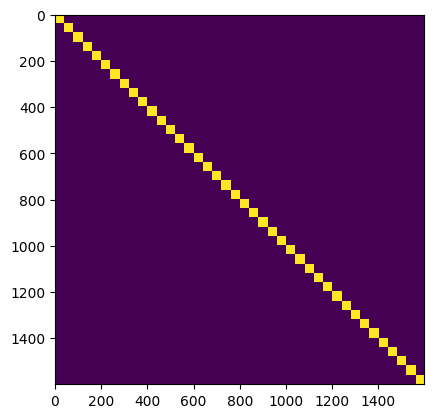

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(gt.cpu().numpy(), cmap='viridis', interpolation='nearest')

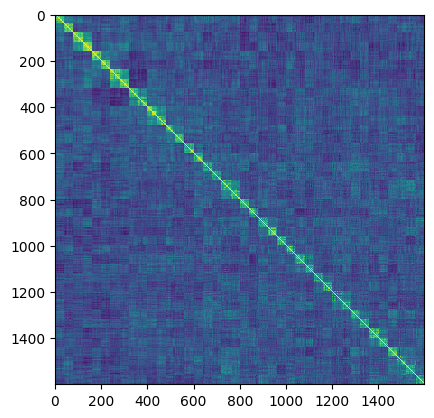

In [21]:
plt.imshow(sim_mat.cpu().numpy(), cmap='viridis', interpolation='nearest')

In [22]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              SiLU-3         [-1, 16, 128, 128]               0
        ConvModule-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           1,024
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              SiLU-7         [-1, 64, 128, 128]               0
        ConvModule-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]             576
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             SiLU-11         [-1, 64, 128, 128]               0
       ConvModule-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]           2,048
      BatchNorm2d-14         [-1, 32, 1

Text(0, 0.5, 'TAR')

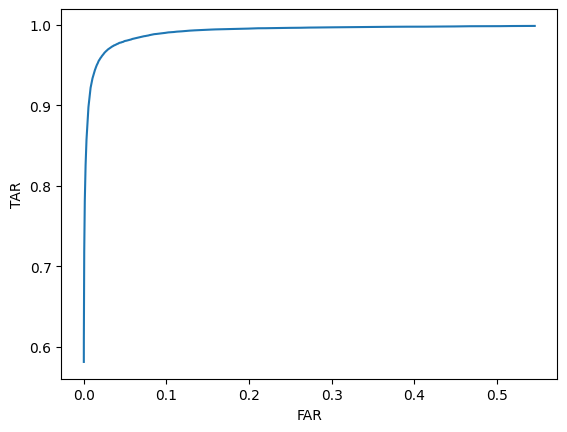

In [29]:
plt.plot(far_list, tpr_list)
plt.xlabel('FAR')
plt.ylabel('TAR')